In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_validate 
from sklearn import metrics

In [3]:
df = pd.read_csv("../data/clean/full_set.csv")

# drop time related features
df.drop(["Time","MidPeriod","year"], axis=1, inplace=True)

# drop country identifying features
df.drop(["Country","country","LocID","Code"], axis=1, inplace=True)

# drop highly correlated variables (to RelMigrations)
df.drop(["CNMR","NetMigrations"], axis=1, inplace=True)

# drop other unwanted columns
df.drop(["change_from_previous_year","Unnamed: 0"], axis=1, inplace=True)

In [4]:
df.head(2)

,TFR,NRR,CBR,Births,LEx,LExMale,LExFemale,IMR,Q5,CDR,...,group_grievance,economy,economic_inequality,human_flight_and_brain_drain,state_legitimacy,public_services,human_rights,demographic_pressures,refugees_and_idps,external_intervention
0,6.478,2.666,42.513,0.042049,59.63,58.34,61.02,72.193,100.008,9.124,...,9.5,8.5,8.1,7.0,9.2,8.3,8.4,9.1,8.9,10.0
1,5.447,2.319,37.098,0.036558,62.32,60.93,63.79,60.100,81.042,7.498,...,9.2,8.2,7.8,7.2,9.4,8.8,8.4,9.3,9.2,10.0


# Create target class

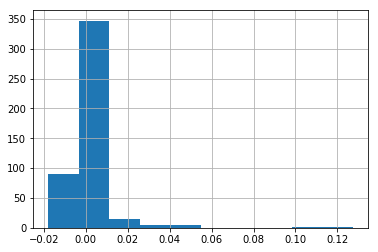

In [18]:
df.RelMigrations.hist()

In [166]:
conditions = [
    (df['RelMigrations'] >= 0.03),
    (df['RelMigrations'] >= 0.005) & (df['RelMigrations'] < 0.03),
    (df['RelMigrations'] < 0.005)]
choices = ['high_migration', 'low_migration', 'no_migration']
df['migration_rank'] = np.select(conditions, choices, default='no_migration')

In [167]:
df.migration_rank.value_counts()

no_migration      400
low_migration      53
high_migration     10
Name: migration_rank, dtype: int64

In [168]:
total_no_migration = df.migration_rank.value_counts()["no_migration"]
total_low_migration = df.migration_rank.value_counts()["low_migration"]
total_high_migration = df.migration_rank.value_counts()["high_migration"]

In [169]:
X = df.drop(["RelMigrations","migration_rank"], axis=1)
y = df.migration_rank

# Scoring

In [170]:
def f1_scorer(classifier, X, y):
    y_pred = classifier.predict(X)
    f1 = metrics.f1_score(y, y_pred, average="weighted")
    return f1

In [171]:
def precision_scorer(classifier, X, y):
    y_pred = classifier.predict(X)
    precision = metrics.precision_score(y, y_pred, average="weighted")
    return precision

In [172]:
def recall_scorer(classifier, X, y):
    y_pred = classifier.predict(X)
    recall = metrics.recall_score(y, y_pred, average="weighted")
    return recall

In [173]:
def confusion_scorer_no(classifier, X, y):
    y_pred = classifier.predict(X)
    m = metrics.confusion_matrix(y, y_pred, labels=["no_migration","low_migration","high_migration"])
    return m[0][1:].sum()

In [174]:
def confusion_scorer_low(classifier, X, y):
    y_pred = classifier.predict(X)
    m = metrics.confusion_matrix(y, y_pred, labels=["no_migration","low_migration","high_migration"])
    return m[1][::2].sum()

In [175]:
def confusion_scorer_high(classifier, X, y):
    y_pred = classifier.predict(X)
    m = metrics.confusion_matrix(y, y_pred, labels=["no_migration","low_migration","high_migration"])
    return m[2][:2].sum()

In [176]:
scoring = {"f1":f1_scorer, "precision":precision_scorer, "recall":recall_scorer, 
           "wrong_high_migration":confusion_scorer_high, "wrong_low_migration":confusion_scorer_low,
           "wrong_no_migration":confusion_scorer_no}

In [177]:
def do_crossval(X, y, classifier):
    scores = cross_validate(classifier, X, y, cv=10, n_jobs=-1, scoring=scoring, return_train_score=False)
    
    precision = round(scores["test_precision"].mean(), 3)
    recall = round(scores["test_recall"].mean(), 3)
    f1 = round(scores["test_f1"].mean(), 3)
    confusion_high = round(scores["test_wrong_high_migration"].sum(), 3)
    confusion_low = round(scores["test_wrong_low_migration"].sum(), 3)
    confusion_no = round(scores["test_wrong_no_migration"].sum(), 3)
    
    return precision, recall, f1, confusion_high, confusion_low, confusion_no

# Random Forest

In [178]:
precision, recall, f1, confusion_high, confusion_low, confusion_no = do_crossval(X, y, RandomForestClassifier(n_estimators=1000, 
                                                                                                              class_weight="balanced"))
print("precision: " + str(precision) + 
      "\nrecall: " + str(recall) +
      "\nf1_score: " + str(f1) + 
      "\nmissclassification rate for high migration cases: " + str(round(confusion_high / total_high_migration * 100, 2)) + "%" +
      "\nmissclassification rate for low migration cases: " + str(round(confusion_low / total_low_migration * 100, 2)) + "%" +
      "\nmissclassification rate for no migration cases: " + str(round(confusion_no / total_no_migration * 100, 2)) + "%"
     )

precision: 0.903
recall: 0.922
f1_score: 0.907
missclassification rate for high migration cases: 40.0%
missclassification rate for low migration cases: 50.94%
missclassification rate for no migration cases: 1.25%


In [111]:
rf_feature_importances = pd.DataFrame(RandomForestClassifier(n_estimators=1000, class_weight="balanced").fit(X,y).feature_importances_).T
rf_feature_importances.columns = X.columns
rf_feature_importances = rf_feature_importances.T
rf_feature_importances.columns = ["importance"]
rf_feature_importances.sort_values(by="importance", ascending=False)

,importance
GrowthRate,0.138320
DeathsFemale,0.054820
DeathsMale,0.053911
Deaths,0.053779
CDR,0.051895
economy,0.044966
PopTotal_20-59,0.044962
PopMale_20-59,0.043704
PopMale,0.038133
PopFemale,0.035508


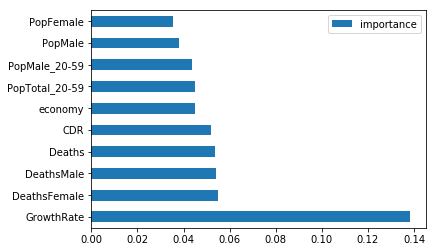

In [183]:
rf_feature_importances.sort_values(by="importance", ascending=False)[:10].plot(kind="barh")

# Ridge

In [189]:
from sklearn.preprocessing import MinMaxScaler

In [190]:
precision, recall, f1, confusion_high, confusion_low, confusion_no = do_crossval(MinMaxScaler().fit_transform(X), y, RidgeClassifier(normalize=True, class_weight="balanced"))
print("precision: " + str(precision) + 
      "\nrecall: " + str(recall) +
      "\nf1_score: " + str(f1) + 
      "\nmissclassification rate for high migration cases: " + str(round(confusion_high / total_high_migration * 100, 2)) + "%" +
      "\nmissclassification rate for low migration cases: " + str(round(confusion_low / total_low_migration * 100, 2)) + "%" +
      "\nmissclassification rate for no migration cases: " + str(round(confusion_no / total_no_migration * 100, 2)) + "%"
     )

C:\Anaconda\envs\fastaienv\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


precision: 0.882
recall: 0.814
f1_score: 0.839
missclassification rate for high migration cases: 20.0%
missclassification rate for low migration cases: 45.28%
missclassification rate for no migration cases: 15.0%


In [191]:
ridge_feature_importances = pd.DataFrame(RidgeClassifier(normalize=True, class_weight="balanced").fit(MinMaxScaler().fit_transform(X),y).coef_)
ridge_feature_importances.columns = X.columns
ridge_feature_importances = ridge_feature_importances.T
ridge_feature_importances.columns = ['no_migration', 'low_migration', 'high_migration']
ridge_feature_importances = ridge_feature_importances.round(3)
ridge_feature_importances.sort_values(by="high_migration", ascending=False)

C:\Anaconda\envs\fastaienv\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,no_migration,low_migration,high_migration
economy,-0.076,-0.347,0.424
PopTotal,-0.158,-0.165,0.323
human_flight_and_brain_drain,-0.059,-0.226,0.285
DeathsMale,-0.232,-0.012,0.244
Deaths,-0.220,0.006,0.214
SRB,-0.158,-0.050,0.208
CDR,-0.214,0.014,0.199
DeathsFemale,-0.205,0.021,0.184
external_intervention,0.016,-0.175,0.159
public_services,-0.122,-0.036,0.158


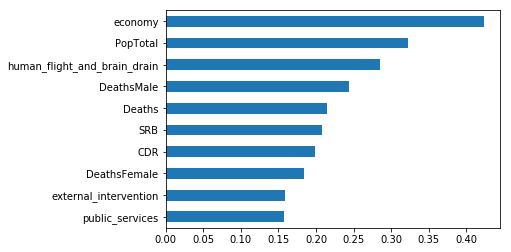

In [195]:
ridge_feature_importances.sort_values(by="high_migration", ascending=True).high_migration[-10:].plot(kind="barh")